<a href="https://colab.research.google.com/github/Telephos/SteeringAngleEstimation/blob/main/SteeringAngleEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------



In [ ]:
# import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# model.eval()

In [ ]:
# model_list = torch.hub.list('pytorch/vision:v0.10.0')
# for m in model_list:
# print(m)

In [ ]:
!lsb_release -a

In [ ]:
!nvcc --version

In [ ]:
!nvidia-smi

In [ ]:
!pip install -q mxnet

     |████████████████████████████████| 49.1 MB 1.3 MB/s 


In [ ]:
!pip install -q gluoncv

     |████████████████████████████████| 1.3 MB 12.9 MB/s 


In [ ]:
# import torch
# import torchvision

!pip install -U openmim
!mim install mmcv-full

In [ ]:
!pip install mmsegmentation

In [ ]:
!mim download mmsegmentation --config pspnet_r50-d8_512x1024_40k_cityscapes --dest .

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing pspnet_r50-d8_512x1024_40k_cityscapes...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /content/MyDrive/MyDrive/Colab Notebooks/AdvCV_Project
Successfully dumped pspnet_r50-d8_512x1024_40k_cityscapes.py to /content/MyDrive/MyDrive/Colab Notebooks/AdvCV_Project


In [ ]:
import os
import cv2 as cv2
os.environ['MXNET_CUDNN_LIB_CHECKING'] = '0'
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'

import torch
import torchvision

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
# using cpu/gpu
ctx = mx.cpu(0)

### Drive mounting and directory

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
%cd /content/MyDrive/MyDrive/Colab Notebooks/AdvCV_Project

/content/MyDrive/MyDrive/Colab Notebooks/AdvCV_Project


In [ ]:
!ls

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor
import mmcv
from google.colab.patches import cv2_imshow
import cv2 as cv2
import PIL
import os
import os.path
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
from mxnet import image
import math
from matplotlib import pyplot as plt
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.13.0+cu116` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### End drive mounting and directory

In [ ]:
# Read input video

import cv2 as cv2

cap = cv2.VideoCapture('video-cart_trim1.mp4')

# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Number of frames: " + str(n_frames))
print("Width: " + str(w))
print("Height: " + str(h))


Number of frames: 374
Width: 1920
Height: 1080


In [ ]:
#Run once rescales all the images in "trim" folder

import PIL
import os
import os.path
from PIL import Image

f = os.path.join(os.getcwd(), "trim1_reduced8x")

for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((240,135))
    img.save(f_img)


### Angle comparison between scaling factors

In [ ]:

import PIL
import os
import os.path
from PIL import Image
import numpy as np

directories = ["mask1", "mask1_reduced2x", "mask1_reduced4x", "mask1_reduced8x"]

for dir in directories:
  f = os.path.join(os.getcwd(), dir)
  for file in os.listdir(f):
      f_img = f+"/"+file
      #img = mpimg.imread(f_img)
      #pNorm = steeringAngle(img)
      print("In " + f_img)
      img = mpimg.imread(f_img)
      pNorm = steeringAngle(img*255)
      print(pNorm)

In [ ]:
mask_values = mpimg.imread("output.png")

In [ ]:
print(mask_values*255)

In [ ]:
def imgToMask(imgDir, maskDir, model):
  #This function provides you with the masks from the seperate frames. 

  f = os.path.join(os.getcwd(), imgDir)
  d = os.path.join(os.getcwd(), maskDir)

  for file in os.listdir(f):
      f_img = f +"/"+ file
      #print(f_img)
      img = image.imread(f_img).as_in_context(ctx)
      imgt = test_transform(img, ctx)
      
      output = model.predict(imgt)
      predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
      mask = get_color_pallete(predict, 'citys')
      mask.save(d + "/" + file)

### End angle comparison between scaling factors

### Pixel count test.

In [ ]:
# Complete function for determining angle from given image
import cv2 as cv2
import numpy as np
import matplotlib.image as mpimg
from mxnet import image

#Importing example image
mmask = mpimg.imread('output.png')

def roadPixelCount(img, colorArray = [128, 64, 128]):

  #Range will be between 128,64,128 BGR
  roadMin = np.array([colorArray[2]-1, colorArray[1]-1, colorArray[0]-1], np.uint8)
  roadMax = np.array([colorArray[2]+1, colorArray[1]+1, colorArray[0]+1], np.uint8)

  #Had to add this stupid factor because the image array is normalized between 0-1.
  pCount = cv2.inRange(img*255, roadMin, roadMax)

  roadCount = cv2.countNonZero(pCount)

  return roadCount

def normImageValue(pCount, w = 1920, h = 1080):
  #This normalizes the road pixel count to total pixel count in the half
  # to values between 0 and 1.

  max = w * h
  normVal = (pCount - 1)/(max - 1)

  return normVal

def ratioImageValue(pCount, w = 1920, h = 1080):

  max = w * h
  ratioVal = pCount/max

  return ratioVal

def normRatio(pDifference):

  min = -1
  max = 1
  normVal = (pDifference - min)/(max - min)

  return normVal

def steeringAngle(img):
  #Provide as a function argument the MASK PNG of the image.
  #Returns pNorm which is the difference of the road pixel to non-road pixels on the left side
  #minues ratio of right side, normalize between 0 and 1

  #Frame shape
  w = int(img.shape[1])
  h = int(img.shape[0])

  half = w//2

  #Get values of channels at middle and bottom of image.
  blue, green, red = img[(int(w//2))][int(h)]*255
  colorArray = [int(blue), int(green), int(red)]

  leftCount = roadPixelCount(mmask[:, :half], colorArray)
  rightCount = roadPixelCount(mmask[:, half:], colorArray)

  leftRatio = ratioImageValue(leftCount, (w//2), (h//2))
  rightRatio = ratioImageValue(rightCount, (w//2), (h//2))

  pNorm = normRatio(rightRatio-leftRatio)

  return pNorm

In [ ]:
#This is an example of how to display 
mtest1 = mpimg.imread("frame6_floodFilled.png")
angle1 = steeringAngle(mtest1*255)
angImg1 = angleLineTheta(mtest1, angle1)
cv2_imshow(angImg1*255) 

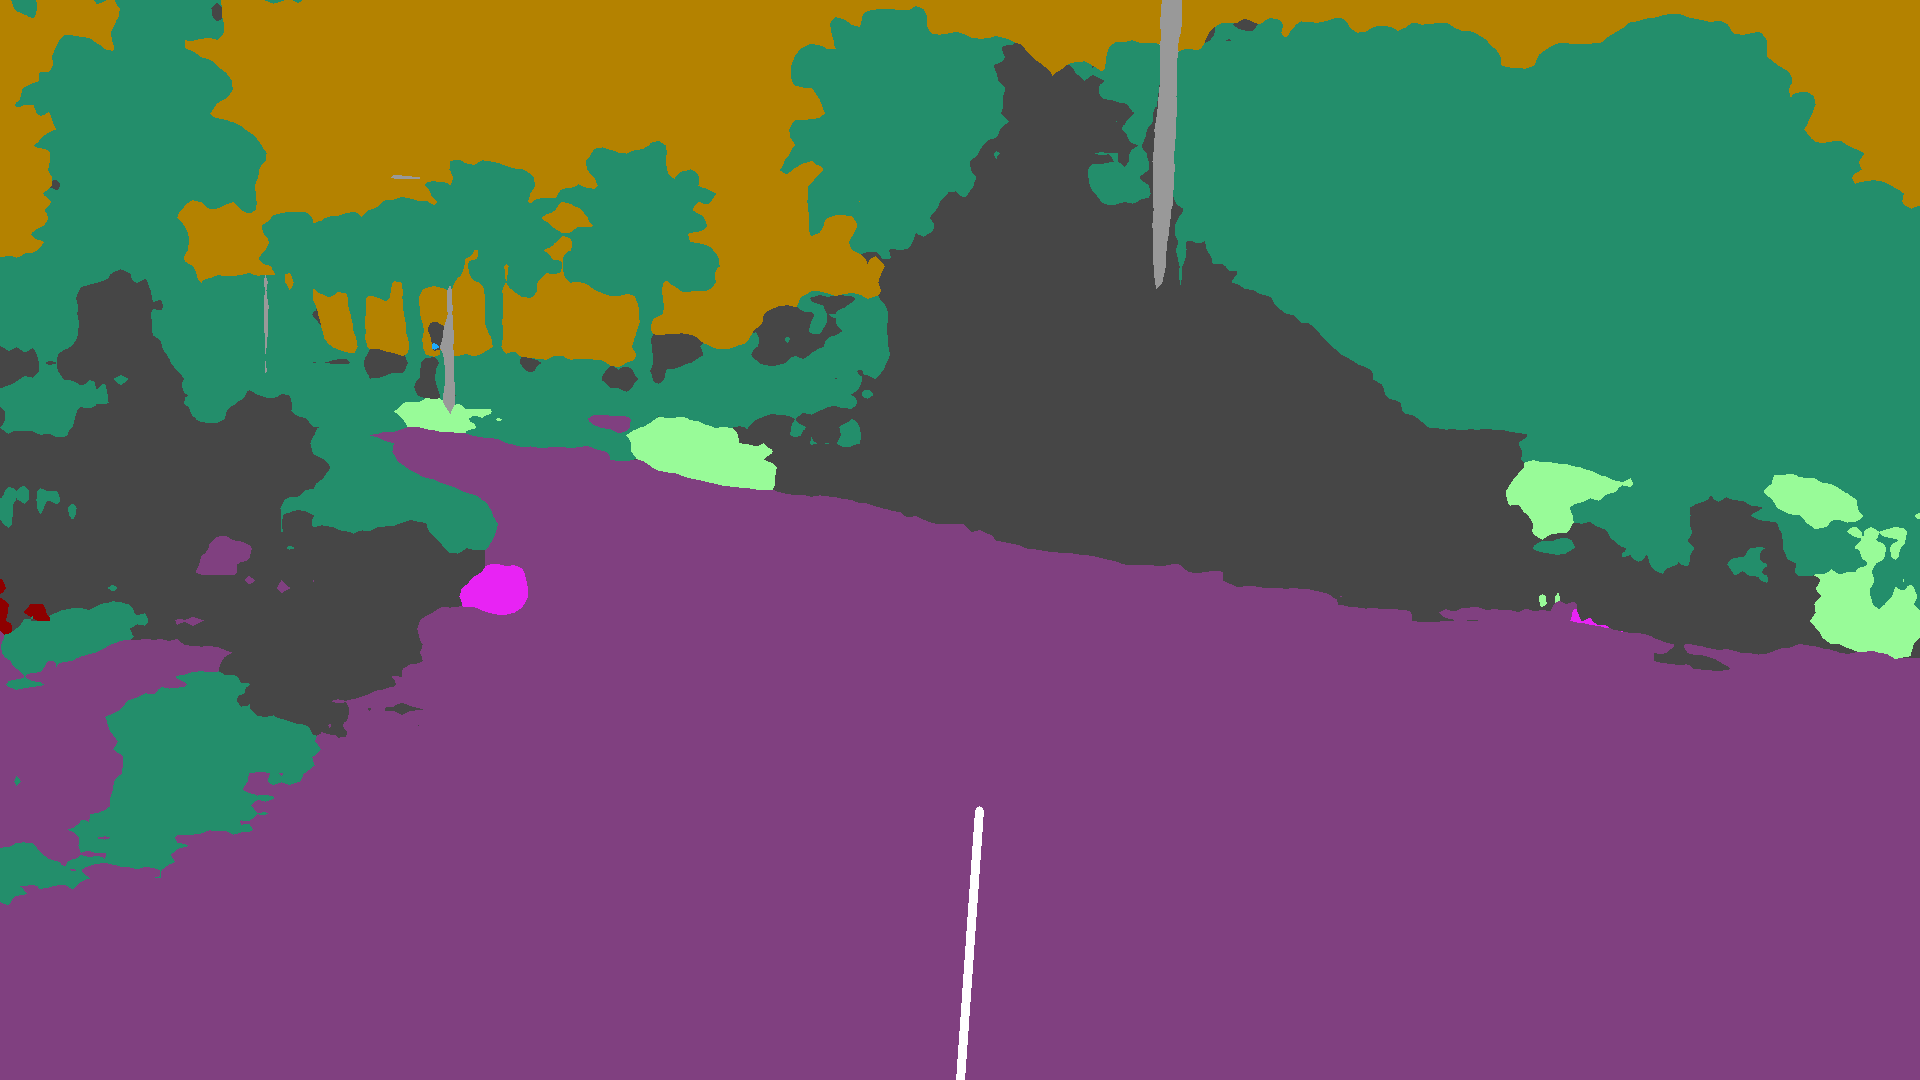

Frame 6 (full size, no CCL): 94.1607638888889


In [ ]:
#Frame 6 full size NO CCL
fr6_noCCL = mpimg.imread("mask1/frame6.png")
fr6_noCCLAngle = steeringAngle(fr6_noCCL*255)
fr6_noCCLimg = angleLineTheta(fr6_noCCL, fr6_noCCLAngle)
cv2_imshow(fr6_noCCLimg*255)
print("Frame 6 (full size, no CCL): " + str(fr6_noCCLAngle*180))

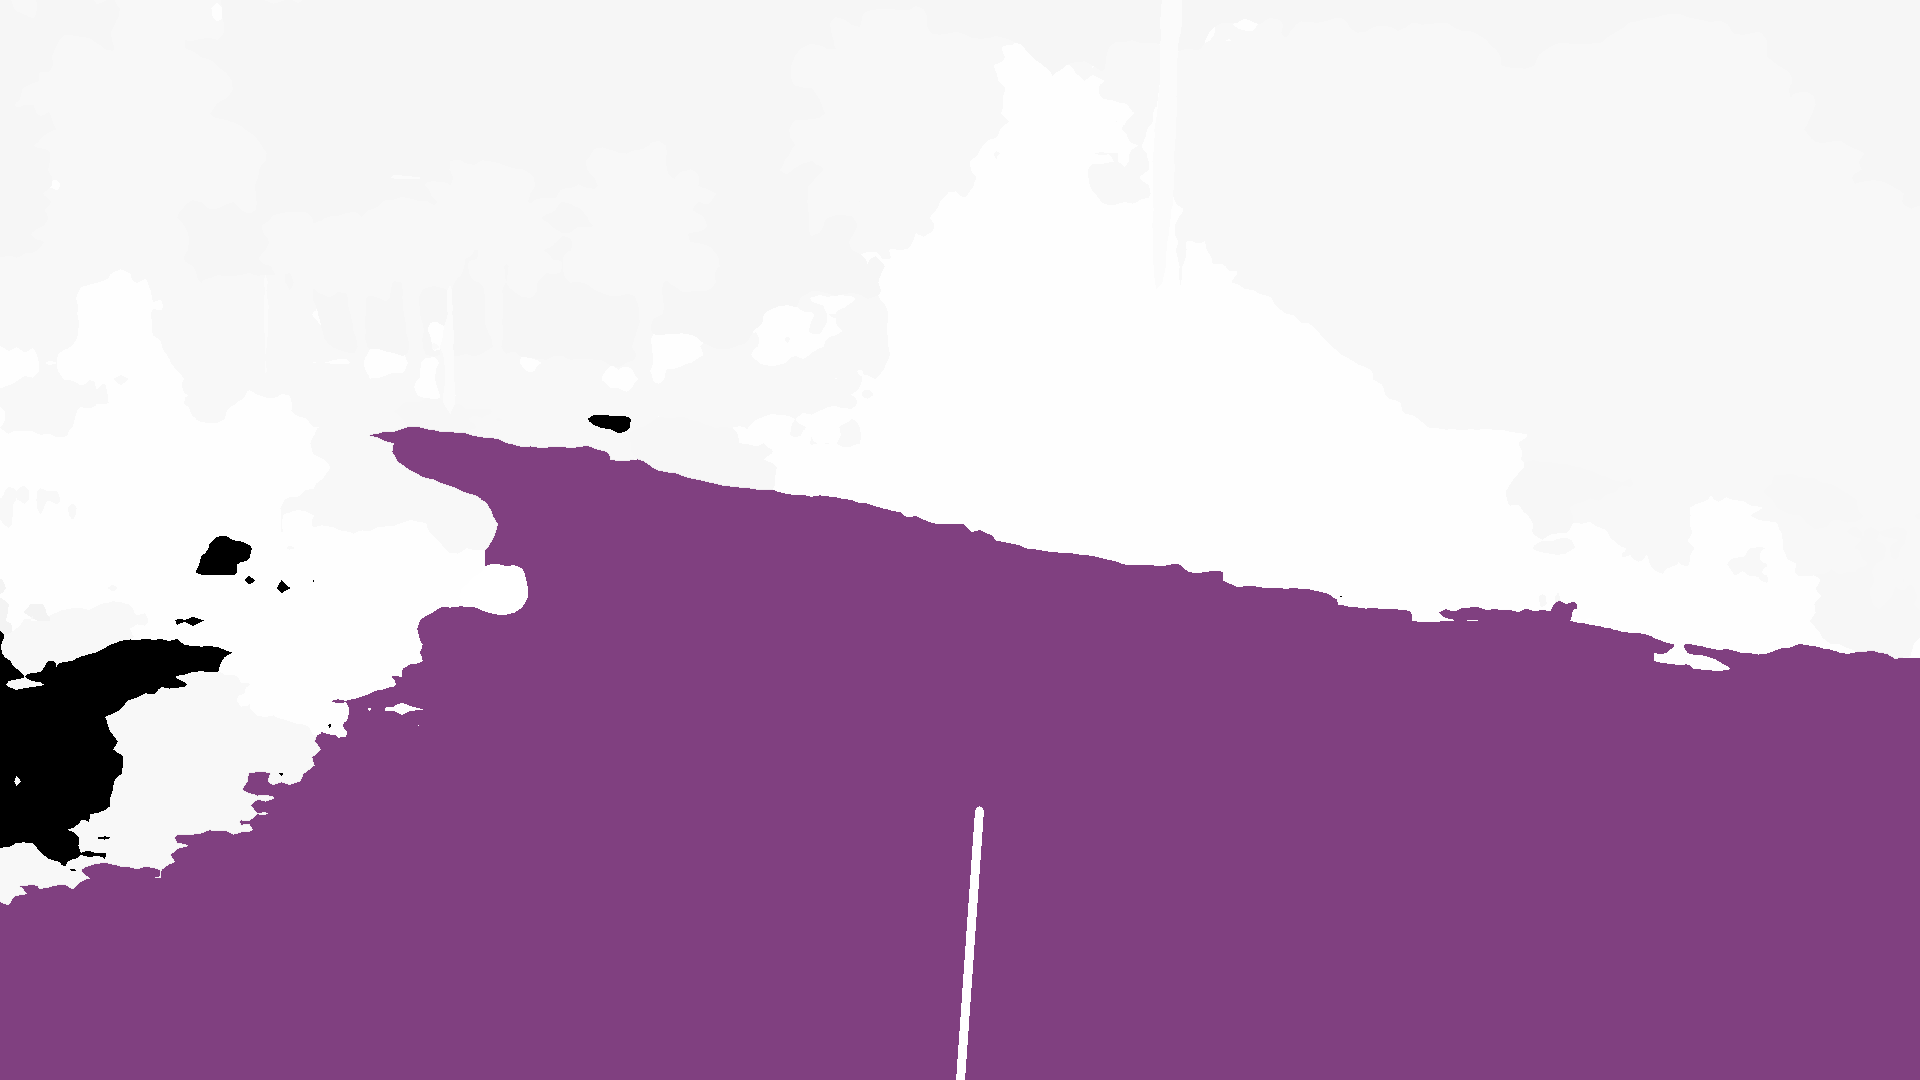

Frame 6 (full size, w CCL): 94.1607638888889


In [ ]:
#Frame 6 full size NO CCL
fr6_wCCL = mpimg.imread("frame6_floodFilled.png")
fr6_CCLAngle = steeringAngle(fr6_wCCL*255)
fr6_CCLimg = angleLineTheta(fr6_wCCL, fr6_CCLAngle)
cv2_imshow(fr6_CCLimg*255)
print("Frame 6 (full size, w CCL): " + str(fr6_CCLAngle*180))

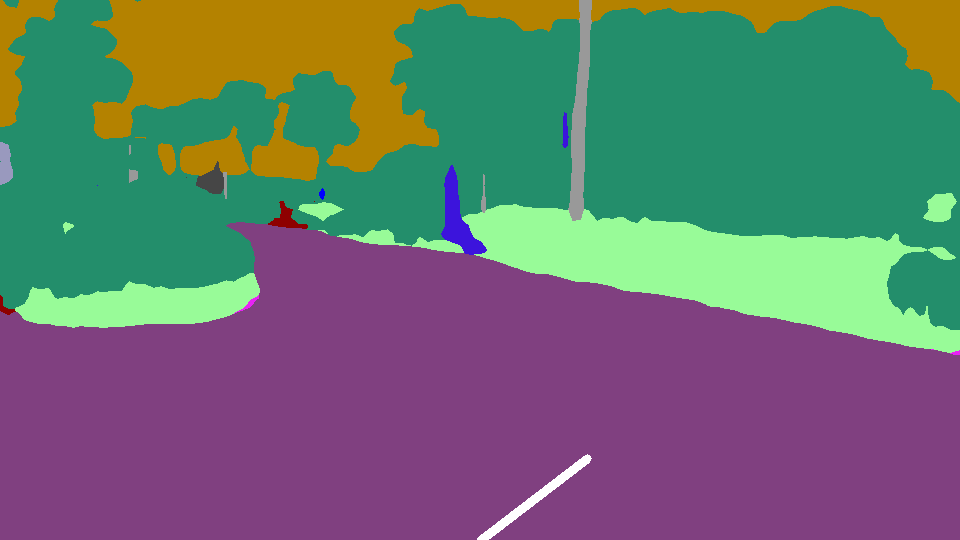

Frame 6 (2x, no CCL): 502.7847222222222


In [ ]:
#Frame 6 2x NO CCL
fr6_2x = mpimg.imread("mask1_reduced2x/frame6.png")
fr6_2xAngle = steeringAngle(fr6_2x*255)
fr6_2ximg = angleLineTheta(fr6_2x, fr6_2xAngle)
cv2_imshow(fr6_2ximg*255)
print("Frame 6 (2x, no CCL): " + str(fr6_2xAngle*180))

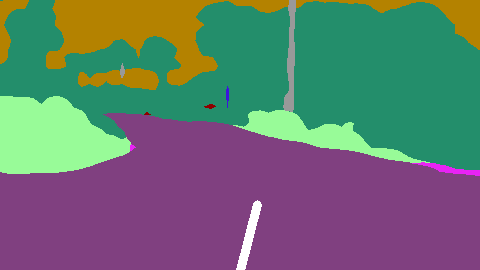

Frame 6 (4x, no CCL): 2265.133333333333


In [ ]:
#Frame 6 4x NO CCL
fr6_4x = mpimg.imread("mask1_reduced4x/frame6.png")
fr6_4xAngle = steeringAngle(fr6_4x*255)
fr6_4ximg = angleLineTheta(fr6_4x, fr6_4xAngle)
cv2_imshow(fr6_4ximg*255)
print("Frame 6 (4x, no CCL): " + str(fr6_4xAngle*180))

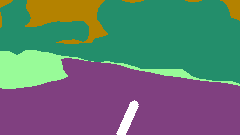

Frame 6 (8x, no CCL): 9475.253731343284


In [ ]:
#Frame 6 8x NO CCL
fr6_8x = mpimg.imread("mask1_reduced8x/frame6.png")
fr6_8xAngle = steeringAngle(fr6_8x*255)
fr6_8ximg = angleLineTheta(fr6_8x, fr6_8xAngle)
cv2_imshow(fr6_8ximg*255)
print("Frame 6 (8x, no CCL): " + str(fr6_8xAngle*180))

### Pixel count test end.

### Line drawing on image.



In [ ]:
#Function for drawing the angle prediction line on an image.

import math
import numpy as np

def angleLineTheta(img, pNormAngle):

  w = int(img.shape[1])
  h = int(img.shape[0])

  theta = (pNormAngle * 180)
  length = 0.25*h

  startX = int(w//2)
  startY = h
  startPoint = (startX, startY)

  endX = int(startX - length * np.cos(np.deg2rad(theta)))
  endY = int(startY - length * np.sin(np.deg2rad(theta)))

  endPoint = (endX, endY)
  color = (100, 200, 100)
  thickness = 7

  img = cv2.line(img, startPoint, endPoint, color, thickness)

  return img

In [ ]:
mmask = cv2.imread('frame6_floodFilled.png')
cv2_imshow(mmask)

### End line drawing on image

### Frame extraction

In [ ]:
# RUN ONCE TO EXTRACT FRAMES

"""
import os
import cv2

parent_dir = os.getcwd() #Current directory
path = os.path.join(parent_dir, 'trim1') 

#vid = cv2.VideoCapture(0, cv2.CAP_DSHOW) #Opens the inbuilt camera, trying to remove delay with second argument
# or uncomment this code to read from a file instead
vid = cv2.VideoCapture("video-cart_trim1.mp4") #this can be commented in favour of using camera over prerecorded

i=0
while(True):
    ret, frame = vid.read() #Capture frame by frame
    
    #Saving frames trim1 as png images
    cv2.imwrite(os.path.join(path, 'frame'+str(i)+'.png'), frame)
    i +=1

    if(i==(n_frames-1)):
      break
            
vid.release()
cv2.destroyAllWindows()
"""

### End frame extraction

### Automated mask generation

In [ ]:
import PIL
import os
import os.path
from PIL import Image
from matplotlib import pyplot as plt
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg

def imgToMask(imgDir, maskDir, model):
  #This function provides you with the masks from the seperate frames. 

  f = os.path.join(os.getcwd(), imgDir)
  d = os.path.join(os.getcwd(), maskDir)

  for file in os.listdir(f):
      f_img = f +"/"+ file
      #print(f_img)
      img = image.imread(f_img).as_in_context(ctx)
      imgt = test_transform(img, ctx)
      
      output = model.predict(imgt)
      predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
      mask = get_color_pallete(predict, 'citys')
      mask.save(d + "/" + file)

In [ ]:
print(os.path.join(os.getcwd(), "trim1_reduced8x"))

/content/MyDrive/MyDrive/Colab Notebooks/AdvCV_Project/trim1_reduced8x


In [ ]:
#Use this to generate masks from the frames you have saved. 

#imgToMask("trim1", "mask1", model)

### End automated mask generation

### Connected component 

In [ ]:
from PIL import Image

def relabel_image2(img: Image) -> Image:
    # Convert the image to a numpy array
    img_array = np.array(img)

    img_array = img_array*255

    # Find all the pixels with RGB values (128,64,128)
    target_pixels = np.argwhere(img_array == (128, 64, 128))

    # Find the size of the largest region of target pixels
    largest_region_size = 0
    largest_region_pixels = []
    for i, j in target_pixels:
        region_pixels = floodfill(img_array, i, j)
        region_size = len(region_pixels)
        if region_size > largest_region_size:
            largest_region_size = region_size
            largest_region_pixels = region_pixels

    # Keep the largest region with its original RGB values
    for i, j in largest_region_pixels:
        img_array[i, j] = (128, 64, 128)

    # Relabel all the other pixels as black pixels
    for i, j in target_pixels:
        if (i, j) not in largest_region_pixels:
            img_array[i, j] = (0, 0, 0)

    # Convert the image back to a PIL image and return it
    return Image.fromarray(img_array)


In [ ]:
# Import the relabel_image function and the Image class from PIL
from PIL import Image
#from relabel_image import relabel_image

# Open the image file using the Image class
img = Image.open("mask1/frame6.png")
#img = mpimg.imread('mask1/frame6.png') 

# Apply the relabel_image function to the image
relabeled_img = relabel_image2(img)

# Save the relabeled image to a file
relabeled_img.save("frame6_ccl2.png")


<ipython-input-160-671b3ec4b61f>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  target_pixels = np.argwhere(img_array == (128, 64, 128))


In [ ]:
width1 = np.array(relabeled_img).shape[1]
height1 = np.array(relabeled_img).shape[0]
seedPoint = (width1//2, height1//2)
test_fill = flood_fill_single(np.array(relabeled_img), seedPoint)

In [ ]:
data = Image.fromarray(test_fill)
data.save('dummy_pic.png')

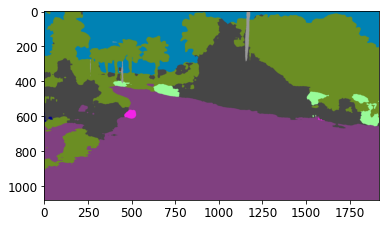

In [ ]:
mmask2 = mpimg.imread('mask1/frame6.png')
plt.imshow(mmask2)

### End connected component

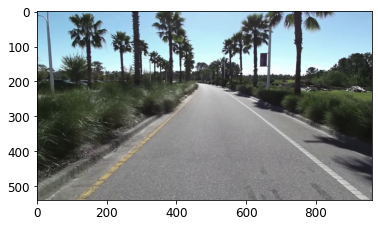

self.crop_size 480


In [ ]:
#url = 'https://github.com/zhanghang1989/image-data/blob/master/encoding/' + \
#    'segmentation/ade20k/ADE_val_00001142.jpg?raw=true'
#filename = 'ade20k_example.jpg'
#gluoncv.utils.download(url, filename, True)

from matplotlib import pyplot as plt

filename = 'trim1_reduced2x/frame200.png'
img = image.imread(filename).as_in_context(ctx)

plt.imshow(img.asnumpy())
plt.show()

imgt = test_transform(img, ctx)

#Loading the model from Gluon library
model = gluoncv.model_zoo.get_model('psp_resnet101_citys', pretrained=True, ctx=ctx)
#model = gluoncv.model_zoo.get_model('psp_resnet101_citys', pretrained=True, ctx=ctx)

output = model.predict(imgt)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()


In [ ]:
from gluoncv.data.transforms.presets.segmentation import test_transform

imgt = test_transform(img, ctx)

#Loading the model from Gluon library
model = gluoncv.model_zoo.get_model('psp_resnet101_citys', pretrained=True, ctx=ctx)
#model = gluoncv.model_zoo.get_model('psp_resnet101_citys', pretrained=True, ctx=ctx)

output = model.predict(imgt)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()


100121KB [00:03, 30468.17KB/s]                           


self.crop_size 480


100%|██████████| 266379/266379 [00:04<00:00, 59627.31KB/s]


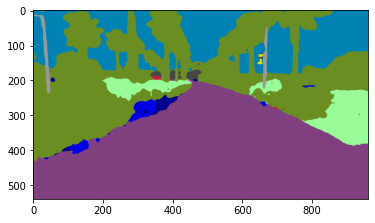

In [ ]:
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg

mask = get_color_pallete(predict, 'citys')
mask.save('output.png')

mmask = mpimg.imread('output.png')
plt.imshow(mmask)


### End saving model

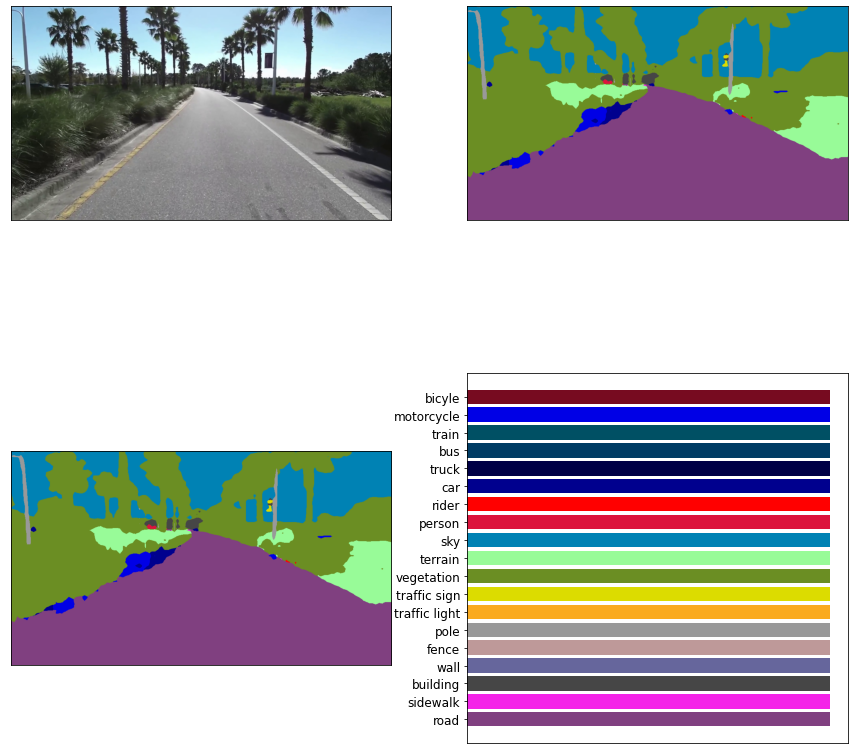

In [ ]:
plt.rc('font', size=12)
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(img.asnumpy())
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
import numpy as np
from matplotlib import pyplot as plt
import gluoncv.utils.viz.segmentation as seg

pallete = seg.cityspallete
labels = list(gluoncv.data.CitySegmentation.CLASSES)
num_classes = gluoncv.data.CitySegmentation.NUM_CLASS

left = np.array(range(num_classes))
height = np.ones(num_classes)
col = []
for i in range(0,num_classes):
    col.append([x/255 for x in pallete[(i*3):(i*3+3)]])

plt.barh(left, height, tick_label=labels, align="center",color=col)
plt.xticks([])
plt.show()

In [ ]:
# FOR GPU RUNTIME

"""
from mmseg.apis import inference_segmentor, init_segmentor
import mmcv

config_file = 'pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = 'trim1/frame0.png'  # or img = mmcv.imread(img), which will only load it once
result = inference_segmentor(model, img)
# visualize the results in a new window
# model.show_result(img, result, show=True)

# or save the visualization results to image files
# you can change the opacity of the painted segmentation map in (0, 1].
model.show_result(img, result, out_file='result.jpg', opacity=0.5)

from google.colab.patches import cv2_imshow
import cv2
cv2_imshow(cv2.imread('result.jpg'))
"""

#Revising above script to run on a cpu

/usr/local/lib/python3.8/dist-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


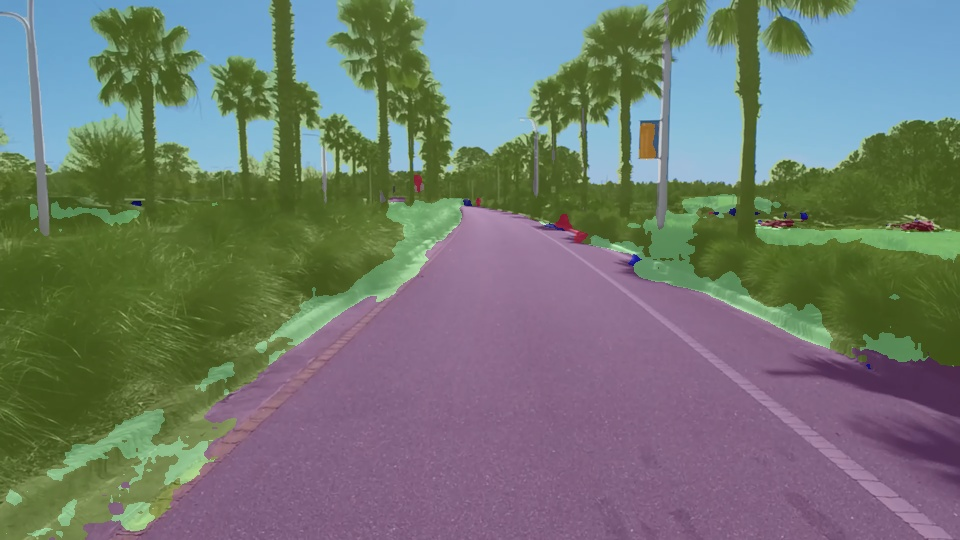

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor
import mmcv
from google.colab.patches import cv2_imshow
import cv2

config_file = 'cpu_pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cpu')

# test a single image and show the results
img = 'trim1_reduced2x/frame200.png'  # or img = mmcv.imread(img), which will only load it once
result = inference_segmentor(model, img)
# visualize the results in a new window
# model.show_result(img, result, show=True)

# or save the visualization results to image files
# you can change the opacity of the painted segmentation map in (0, 1].
model.show_result(img, result, out_file='result.jpg', opacity=0.5)

cv2_imshow(cv2.imread('result.jpg'))
